In [13]:
import pandas as pd
from asodesigner.consts import *
from asodesigner.file_utils import read_human_genome_fasta_dict

all_data = pd.read_csv(DATA_PATH / 'data_from_article_fixed.csv')

In [14]:
from data_genertion.consts import *

### pairwise comparison

In [15]:
# how many Cell lines are in the data, print cell line and size
cell_lines = all_data['Cell_line'].unique()
sum = 0
for cell_line in cell_lines:
    size = all_data[all_data['Cell_line'] == cell_line].shape[0]
    sum += size*(size-1)/2
    print(f'Cell line: {cell_line}, Size: {size}')
    
print(f'Total number of pairs: {sum}')


Cell line: A431, Size: 6559
Cell line: NCI-H460, Size: 18
Cell line: SH-SY5Y, Size: 1767
Cell line: Human IPS, Size: 24
Cell line: LLC-MK2 monkey, Size: 2
Cell line: KARPAS-229, Size: 987
Cell line: A-431, Size: 126
Cell line: MM.1R, Size: 3396
Cell line: SK-MEL-28, Size: 2876
Cell line: H929, Size: 73
Cell line: KMS11, Size: 52
Cell line: HepG2, Size: 6104
Cell line: SNU-449, Size: 1119
Cell line: HepaRG, Size: 6749
Cell line: Hela, Size: 128
Cell line: SK cells asyn, Size: 232
Cell line: PAC neurons asyn, Size: 264
Cell line: Angptl2/Actin, Size: 376
Cell line: Tubulin, Size: 804
Cell line: Oscillation, Size: 181
Cell line: Human Neuronal Cell, Size: 3899
Cell line: Mouse Primary Neuronal Cell, Size: 106
Cell line: U251, Size: 138
Cell line: CC-2580, Size: 910
Total number of pairs: 83995035.0


In [16]:
import pandas as pd
from itertools import combinations
from tqdm.auto import tqdm

# group by 'Cell_line' that has less than 1000 rows
all_data = all_data[all_data['Cell_line'].isin(
    all_data['Cell_line'].value_counts()[all_data['Cell_line'].value_counts() < 1000].index)]

def generate_pairwise_cl_diffs(df_cl,name):
    local_list = []
    for aso1, aso2 in combinations(df_cl['ISIS'].unique(), 2):
        row1 = df_cl[df_cl['ISIS'] == aso1]
        row2 = df_cl[df_cl['ISIS'] == aso2]

        if not row1.empty and not row2.empty:
            diff = row1['Inhibition(%)'].iloc[0] - row2['Inhibition(%)'].iloc[0]
            
            local_list.append({
                'Cell_line': name,
                'ASO1':        aso1,
                'ASO2':        aso2,
                'Diff':        diff
            })
    return local_list

def generate_pairwise_diffs(df, out_csv):
    
    master_df = pd.DataFrame(columns=['Cell_line', 'ASO1', 'ASO2', 'Diff'])
    
    cell_groups = list(df.groupby('Cell_line'))
    cell_line_names = [name for name, _ in cell_groups]
    
    # Iterate over each cell line and generate pairwise differences
    for name in tqdm(cell_line_names, desc='Processing cell lines'):
        df_cl = df[df['Cell_line'] == name]
        
        # Generate pairwise differences for the current cell line
        local_list = generate_pairwise_cl_diffs(df_cl, name)
        
        # Create a DataFrame from the local list
        local_df = pd.DataFrame(local_list, columns=['Cell_line', 'ASO1', 'ASO2', 'Diff'])
        
        # Append to the master DataFrame
        master_df = pd.concat([master_df, local_df], ignore_index=True)
    # Save the master DataFrame to a CSV file
    master_df.to_csv(out_csv, index=False)

out_csv = 'pairwise_diffs_1000.csv'
generate_pairwise_diffs(all_data, out_csv)


Processing cell lines:   0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipykernel_2545/2569019944.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master_df = pd.concat([master_df, local_df], ignore_index=True)
/tmp/ipykernel_2545/2569019944.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master_df = pd.concat([master_df, local_df], ignore_index=True)


In [17]:
# the question we are trying to answer is do cell lines react differently to a specific feature, e.g CG content
# to answer this we need to calculate the difference in inhibition between two ASOs for each cell line
# then we need to calculate the difference in the feature for the two ASOs (e.g difference in % of CG content)
# then we can plot the difference in inhibition against the difference in feature for each cell line

In [24]:
# ASO Pairwise Ranking with LightGBM LambdaRank

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

# === Load Data ===
pairs_df = pd.read_csv("pairwise_diffs_1000.csv")

# === Compute GC Content ===
all_data['GC_content'] = all_data['Sequence'].str.count('[GC]') / all_data['Sequence'].str.len()
gc_lookup = all_data.groupby('ISIS')['GC_content'].first()

# === Map GC features to ASO1 and ASO2 ===
pairs_df['GC_1'] = pairs_df['ASO1'].map(gc_lookup)
pairs_df['GC_2'] = pairs_df['ASO2'].map(gc_lookup)
pairs_df = pairs_df.dropna(subset=['GC_1', 'GC_2'])

# === Feature Matrix and Label ===
X = pairs_df[['GC_1', 'GC_2']]
y = (pairs_df['Diff'] > 0).astype(int)

# === Encode Cell Line to Groups ===
pairs_df['group_base'] = LabelEncoder().fit_transform(pairs_df['Cell_line'])

# === Split Large Groups into Subgroups ===
def split_large_groups(df, max_size=10000):
    new_group_ids = []
    for group_id, group_df in df.groupby('group_base'):
        n = len(group_df)
        chunks = (n // max_size) + 1
        split_ids = [f"{group_id}_{i}" for i in range(chunks)]
        repeats = [split_ids[i // max_size] for i in range(n)]
        new_group_ids.extend(repeats)
    return pd.Series(new_group_ids, index=df.index)

pairs_df['group'] = split_large_groups(pairs_df)
group_sizes = pairs_df.groupby('group').size().values

# === LightGBM Dataset and Training ===
lgb_data = lgb.Dataset(X, label=y, group=group_sizes)
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [1, 3],
    'learning_rate': 0.1,
    'verbose': -1
}
ranker = lgb.train(params, lgb_data, num_boost_round=100)

# === Predict and Save Ranked Results ===
pairs_df['score'] = ranker.predict(X)
ranked = pairs_df.sort_values(['group', 'score'], ascending=[True, False])
ranked[['Cell_line', 'ASO1', 'ASO2', 'score']].to_csv("ranked_pairs.csv", index=False)
print("✅ Saved: ranked_pairs.csv")


✅ Saved: ranked_pairs.csv


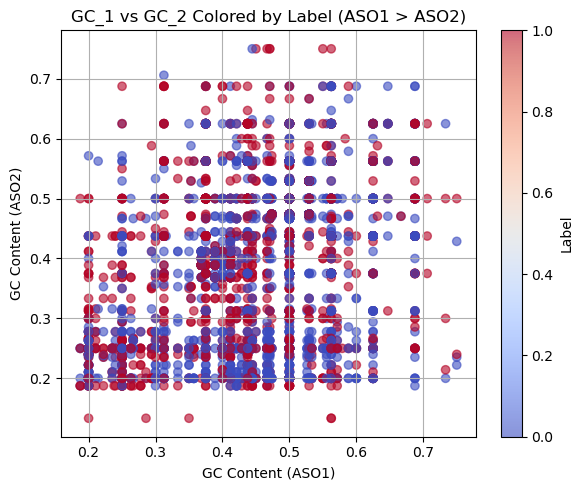

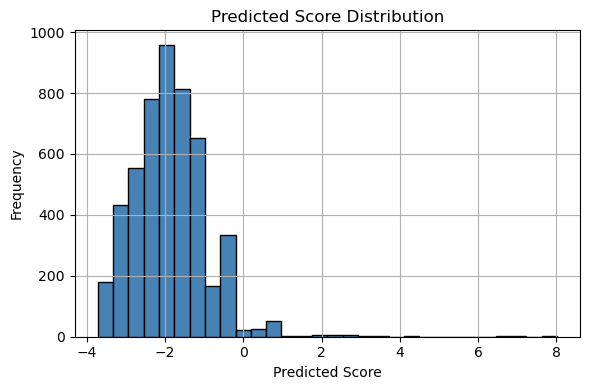

In [27]:
import matplotlib.pyplot as plt

# Sample if needed to avoid memory issues
sample_df = pairs_df.copy()
if len(sample_df) > 5000:
    sample_df = sample_df.sample(n=5000, random_state=42)

# Scatter plot of GC_1 vs GC_2
plt.figure(figsize=(6, 5))
plt.scatter(sample_df['GC_1'], sample_df['GC_2'],
            c=(sample_df['Diff'] > 0).astype(int), cmap='coolwarm', alpha=0.6)
plt.xlabel("GC Content (ASO1)")
plt.ylabel("GC Content (ASO2)")
plt.title("GC_1 vs GC_2 Colored by Label (ASO1 > ASO2)")
plt.colorbar(label="Label")
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram of scores (if available)
if 'score' in sample_df.columns:
    plt.figure(figsize=(6, 4))
    plt.hist(sample_df['score'], bins=30, color='steelblue', edgecolor='black')
    plt.xlabel("Predicted Score")
    plt.ylabel("Frequency")
    plt.title("Predicted Score Distribution")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Column 'score' not found. Train the model first.")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats

# ========== Load Data ==========
# Update these paths to your actual file locations:
pairs_df = pd.read_csv('pairwise_diffs_1000.csv')   # expects columns: ['Cell_line','ASO1','ASO2','Diff', ...]

# ========== Compute Feature ==========
# Example: GC content feature
all_data['GC_content'] = all_data['Sequence'].str.count('G|C') / all_data['seq_length']
gc_lookup = all_data.drop_duplicates('ISIS').set_index('ISIS')['GC_content']

print(all_data[['ISIS', 'Sequence', 'GC_content']].head())

# Map Δ feature onto pairs
pairs_df['Diff_GC_content'] = (
    pairs_df['ASO1'].map(gc_lookup)
    - pairs_df['ASO2'].map(gc_lookup)
)

# ========== Linear Regression per Cell Line ==========
for cell_line, group in pairs_df.groupby('Cell_line'):
    x = group['Diff_GC_content'].to_numpy().reshape(-1, 1)  # feature matrix
    y = group['Diff'].to_numpy()                            # target vector

    # Skip groups without variance
    if len(group) < 2 or np.unique(x).size < 2:
        continue

    # Fit Linear Regression
    model = LinearRegression()
    model.fit(x, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(x, y)

    # Generate prediction line
    x_line = np.array([[x.min()], [x.max()]])
    y_line = model.predict(x_line)
    #  calculate also p-value
    p_value = stats.linregress(x.flatten(), y).pvalue
    print(f"Cell line: {cell_line}, Slope: {slope:.3f}, Intercept: {intercept:.3f}, R²: {r2:.3f}, p-value: {p_value:.3f}")

    # Plot
    # plt.figure(figsize=(6, 4))
    # plt.scatter(x, y, alpha=0.6, label='Data points')
    # plt.plot(x_line, y_line, 'r--', linewidth=2, label=f'Fit: y={slope:.3f}x+{intercept:.3f}')
    # plt.title(f"{cell_line}\nR² = {r2:.3f}")
    # plt.xlabel('Δ GC content')
    # plt.ylabel('Δ Inhibition (%)')
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

# # ========== Optional: Plotting All Cell Lines Together ==========
# plt.figure(figsize=(10, 6))
# for cell_line, group in pairs_df.groupby('Cell_line'):
#     x = group['Diff_GC_content'].to_numpy().reshape(-1, 1)
#     y = group['Diff'].to_numpy()
    
#     # Skip groups without variance
#     if len(group) < 2 or np.unique(x).size < 2 :
#         continue
    
#     model = LinearRegression()
#     model.fit(x, y)
#     y_pred = model.predict(x_line)
    
#     plt.plot(x_line, y_pred, label=cell_line)

# plt.xlabel('Δ GC content')
# plt.ylabel('Δ Inhibition (%)')
# plt.title('Linear Trendlines by Cell Line')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
# plt.tight_layout()
# plt.show()



       ISIS          Sequence  GC_content
927  651530  TGACTAATAGCAGTGG      0.4375
928  651555  TTTAATGTCACAAGCA      0.3125
929  651587  GATTTGTCAGCAGGAC      0.5000
930  651987  GCTATTAGGAGTCTTT      0.3750
931  695785  AATGGTGAATATCTTC      0.3125
Cell line: Angptl2/Actin, Slope: -68.959, Intercept: 1.857, R²: 0.073, p-value: 0.000
Cell line: CC-2580, Slope: -326.716, Intercept: -0.448, R²: 0.072, p-value: 0.000
Cell line: H929, Slope: -62.209, Intercept: 2.890, R²: 0.085, p-value: 0.000
Cell line: Human IPS, Slope: -89.900, Intercept: 10.099, R²: 0.173, p-value: 0.000
Cell line: KARPAS-229, Slope: -52.621, Intercept: -0.004, R²: 0.057, p-value: 0.000
Cell line: KMS11, Slope: -91.282, Intercept: 1.497, R²: 0.229, p-value: 0.000
Cell line: Mouse Primary Neuronal Cell, Slope: 48.883, Intercept: 4.106, R²: 0.065, p-value: 0.000
Cell line: NCI-H460, Slope: 15.975, Intercept: -4.295, R²: 0.008, p-value: 0.258
Cell line: Oscillation, Slope: 13.535, Intercept: -6.119, R²: 0.002, p-value: 